In [1]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from gensim import corpora
from gensim.models import LdaModel

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Q1

In [33]:
# DO NOT MODIFY THIS CODE
website_visits_data = np.loadtxt('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/website_visits.csv', delimiter=',')

## (a)

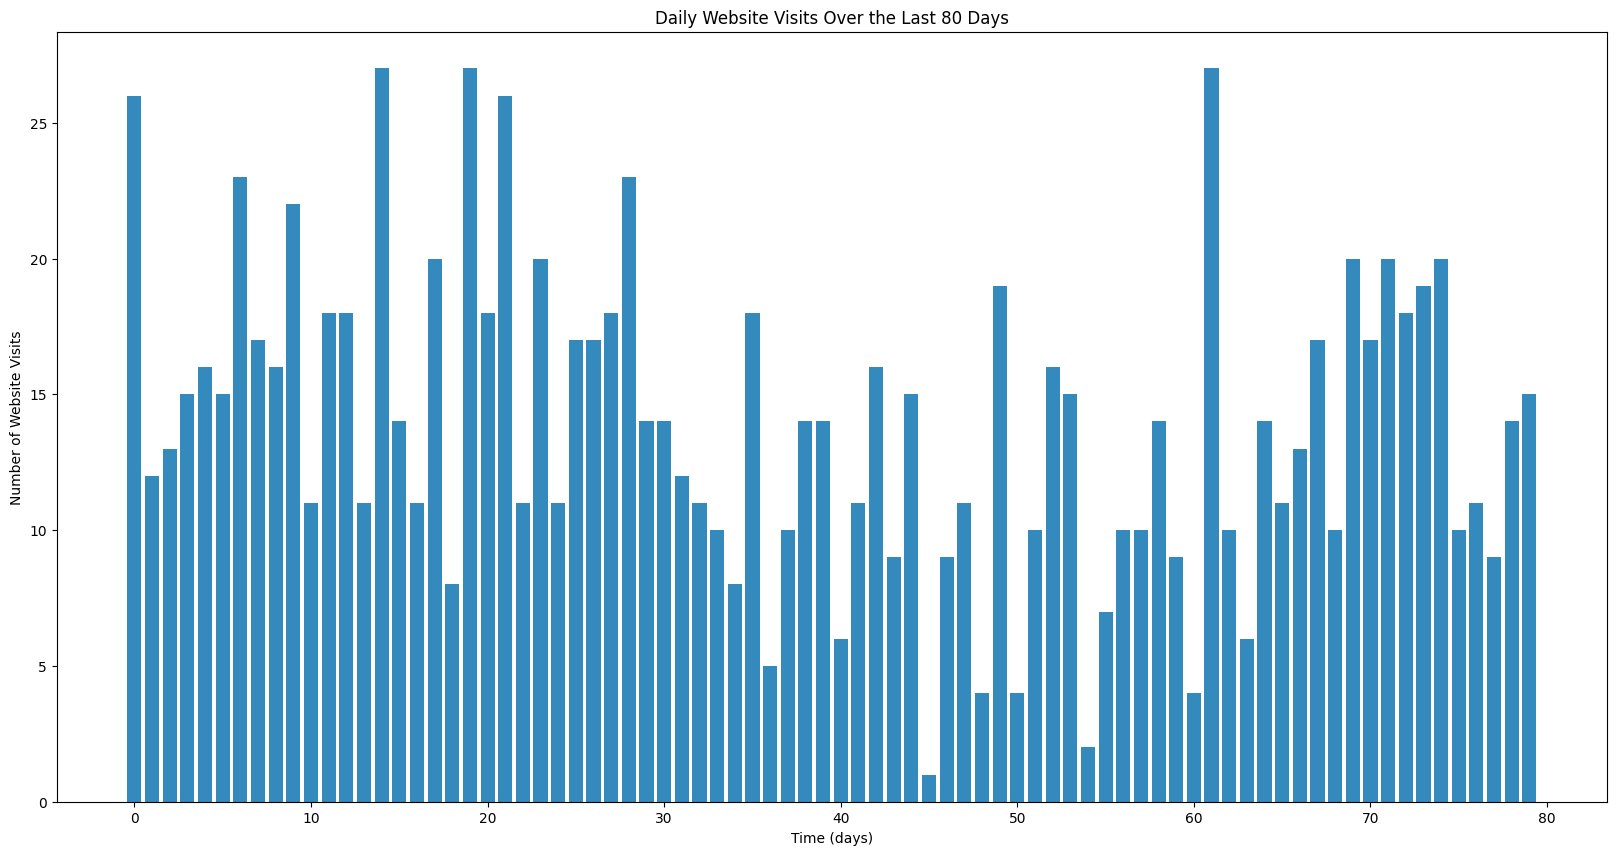

In [5]:
# YOUR CODE STARTS HERE
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(website_visits_data)), website_visits_data, color="#348ABD")
plt.xlabel('Time (days)')
plt.ylabel('Number of Website Visits')
plt.title('Daily Website Visits Over the Last 80 Days')
plt.show()


**Enter your answer here:** The visualization suggests multiple switchpoints, as indicated by the apparent changes in the level of website visits over time, with periods of relative consistency followed by abrupt changes in the frequency of visits.

## (b)

In [17]:
# DO NOT MODIFY THIS CODE

param_names = ['tau_1', 'tau_2', 'lambda_1', 'lambda_2', 'lambda_3']

double_switchpoint_model = pm.Model()

with double_switchpoint_model:

  # Define priors
  # YOUR CODE STARTS HERE (FILL IN THE BLANKS)
  alpha = 1.0 / np.mean(website_visits_data)

  tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=79)
  tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper=79)
  lambda_1 = pm.Exponential("lambda_1", alpha)
  lambda_2 = pm.Exponential("lambda_2", alpha)
  lambda_3 = pm.Exponential("lambda_3", alpha)

  idx = np.arange(len(website_visits_data))
  lambda_ = pm.math.switch(idx < tau_1, lambda_1, pm.math.switch(idx < tau_2, lambda_2, lambda_3))

  # Define likelihood (conditioned on observed data)
  # YOUR CODE STARTS HERE (FILL IN THE BLANK)
  likelihood = pm.Poisson("visits", lambda_, observed=website_visits_data)

  # Sample from posterior
  # YOUR CODE STARTS HERE (FILL IN THE BLANK)
  trace = pm.sample(1000, random_seed=45)

## (c)

In [20]:
# Function to: (a) plot histogram of posterior samples (b) display mean and 94% HDI of posterior samples

def plot_posterior(param_names, trace):

    # (a) Plot histogram of posterior samples of passed parameter
    # YOUR CODE STARTS HERE
    samples = trace.posterior[param_name].values.flatten()
    ax = sns.histplot(samples, color='skyblue')
    ax.set_xlim(0, samples.max())
    plt.xlabel(param_name)
    plt.ylabel('Number of Samples')
    plt.title(f'Histogram of Posterior Samples of {param_name}')
    mean_sample = np.mean(samples)
    hdi_sample = az.hdi(samples, hdi_prob=0.94)
    plt.axvline(x=mean_sample, color='red', linestyle='--', label=f'Mean: {mean_sample:.2f}')
    plt.axvline(x=hdi_sample[0], color='orange', linestyle='--', label='3% HDI')
    plt.axvline(x=hdi_sample[1], color='orange', linestyle='--', label='97% HDI')
    plt.legend()

    # (b) Display mean and 94% HDI of posterior samples of passed parameter (round to 2 decimal places)
    # YOUR CODE STARTS HERE
    print(f"\nMean of {param_name}: {mean_sample}")
    print(f"94% HDI of {param_name}: [{hdi_sample[0]:.2f}, {hdi_sample[1]:.2f}]")

    return None


Mean of tau_1: 30.7095
94% HDI of tau_1: [29.00, 33.00]


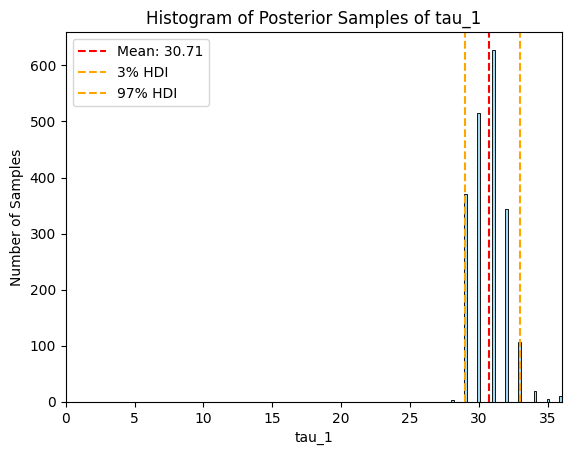


Mean of tau_2: 63.0425
94% HDI of tau_2: [59.00, 69.00]


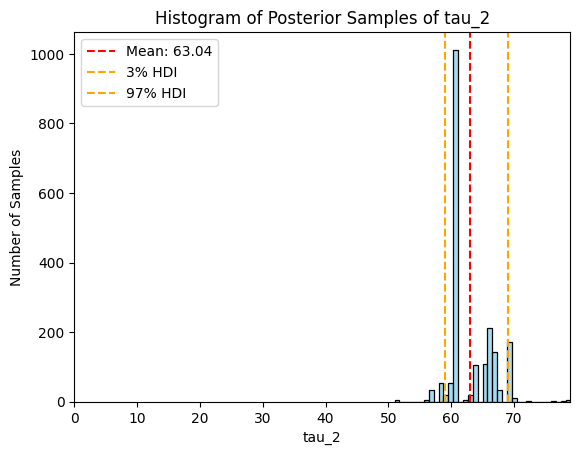


Mean of lambda_1: 17.057806481093003
94% HDI of lambda_1: [15.57, 18.54]


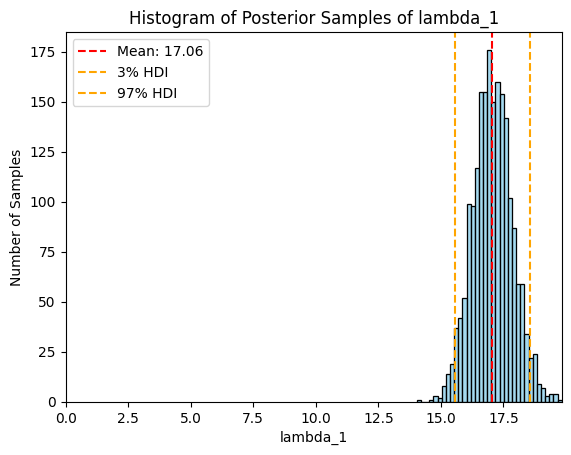


Mean of lambda_2: 10.430343240989755
94% HDI of lambda_2: [9.25, 11.56]


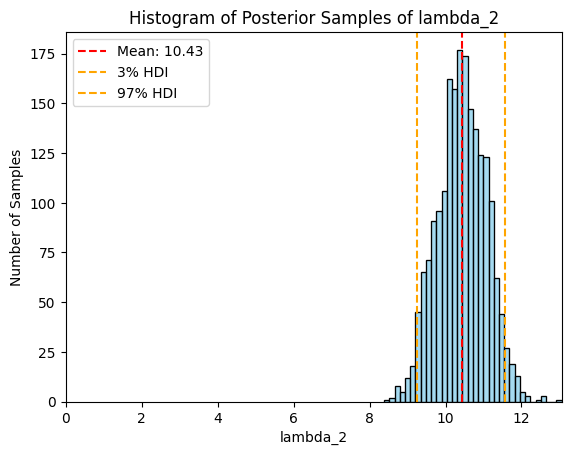


Mean of lambda_3: 14.88168074631954
94% HDI of lambda_3: [12.99, 17.04]


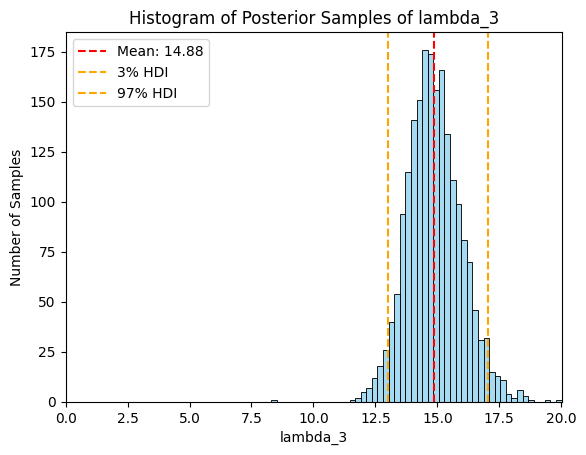

In [21]:
# DO NOT MODIFY THIS CODE
for param_name in param_names:
    plot_posterior(param_name, trace)
    plt.show()

**Enter answer here:** (i) The current model may not be a good fit since the HDI ranges for the switchpoints (tau_1 and tau_2) are narrow and indicate certainty in switchpoint locations that does not reflect the apparent variability and overlap in the count data from the bar graph.

(ii) The histograms of the posterior samples for lambda parameters seem narrowly distributed, which suggests a higher level of certainty about the Poisson rates than what the variability in the bar graph of the observed data might suggest. This could imply that the model is overly confident about the rate parameters and might not be capturing the true underlying process accurately.


## (d)

In [22]:
# DO NOT MODIFY THIS CODE

double_switchpoint_model_adjusted = pm.Model()

with double_switchpoint_model_adjusted:

  # Define priors
  # YOUR CODE STARTS HERE
  alpha = 1.0 / np.mean(website_visits_data)
  tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=79)
  tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=79)  # hyperprior: tau_2 depends on tau_1
  lambda_1 = pm.Exponential("lambda_1", alpha)
  lambda_2 = pm.Exponential("lambda_2", alpha)
  lambda_3 = pm.Exponential("lambda_3", alpha)
  idx = np.arange(len(website_visits_data))
  lambda_ = pm.math.switch(idx < tau_1, lambda_1, pm.math.switch(idx < tau_2, lambda_2, lambda_3))

  # Define likelihood (conditioned on observed data)
  # YOUR CODE STARTS HERE
  likelihood = pm.Poisson('visits', mu=lambda_, observed=website_visits_data)

  # Sample from posterior
  # YOUR CODE STARTS HERE
  trace_adjusted = pm.sample(1000, random_seed=45)

**Enter your answer here:** The lower bound of tau_2 is equal to tau_1.

## (e)


Mean of tau_1: 30.687
94% HDI of tau_1: [29.00, 33.00]


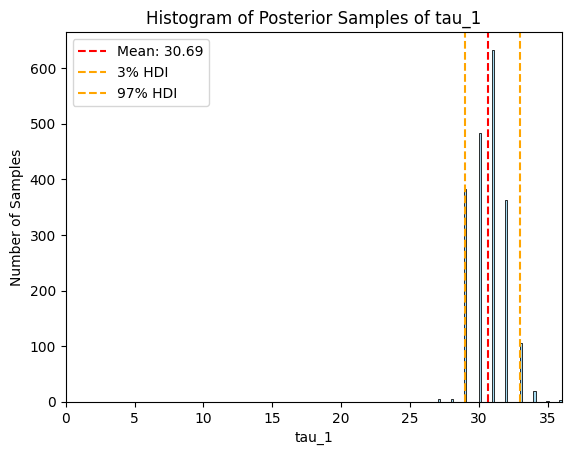


Mean of tau_2: 63.0095
94% HDI of tau_2: [60.00, 68.00]


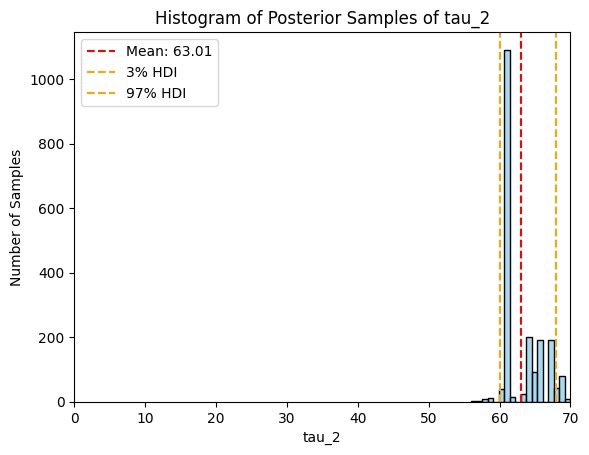


Mean of lambda_1: 17.063852209041627
94% HDI of lambda_1: [15.69, 18.45]


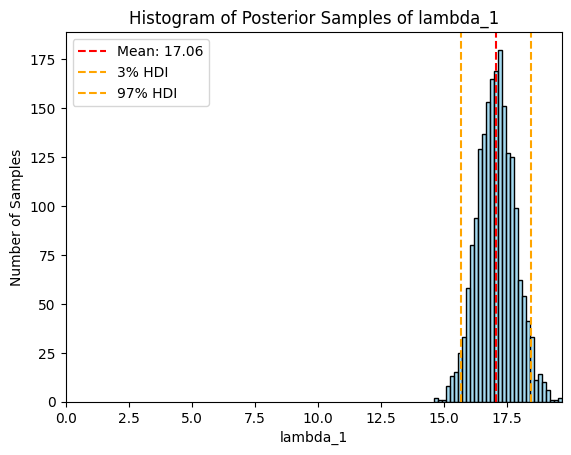


Mean of lambda_2: 10.43225281868465
94% HDI of lambda_2: [9.28, 11.54]


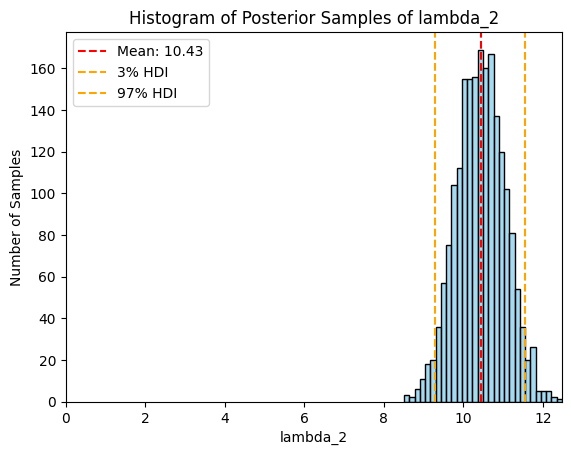


Mean of lambda_3: 14.923616208641993
94% HDI of lambda_3: [13.09, 16.69]


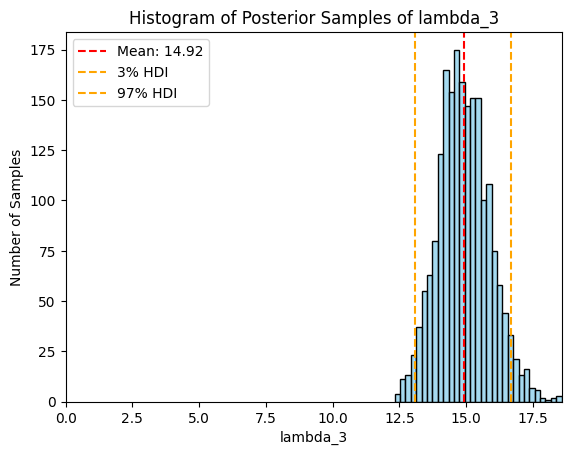

In [23]:
# YOUR CODE GOES HERE
for param_name in param_names:
    plot_posterior(param_name, trace_adjusted)
    plt.show()


**Enter answer here:** (i) The histograms for tau_1 and tau_2 indicate narrow HDI ranges, suggesting that the model is quite certain about the location of these switchpoints, which may or may not be consistent with the actual data variability.

(ii) Based on the bar graph trends observed earlier, we would expect a wider range of possible values for the lambda parameters, indicating multiple plausible rates of website visits. The narrow distributions here could suggest that the model does not fully capture the possible variability in the visit rates, and the posterior samples might not align with the data as well as they should.

# Q2

In [24]:
topic_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/topic_dataset.csv')
topic_df["preprocessed"] = topic_df["preprocessed"].apply(lambda x: ast.literal_eval(x))
topic_df.head()

,document,preprocessed
0,Hi Xperts!\n\nHow can I move the cursor with t...,"[xperts, cursor, keyboard, cursor, key, mouse,..."
1,Where can I obtain a copy of the Open Look wid...,"[obtain, copy, open, look, widget, obtainable,..."
2,\nYou're right about the signal being strong. ...,"[right, signal, strong, live, west, philadelph..."
3,"\nHe's a Canadian ""thing"". Former coach of the...","[canadian, thing, coach, boston, bruin, colora..."
4,"\n\n Heck, I seem to feel like that *ev...","[heck, feel, like, time, including, cafeteria,..."


## (a)

In [28]:
## YOUR CODE GOES HERE
def pre_process(docs):
  texts = docs
  dictionary = corpora.Dictionary(texts)
  print('Number of unique tokens before:', len(dictionary))
  dictionary.filter_extremes(no_below=2, no_above=0.5)

  print('Number of unique tokens after:', len(dictionary))

  corpus = [dictionary.doc2bow(text) for text in texts]

  return texts, dictionary, corpus

topic_texts, dictionary, corpus = pre_process(topic_df['preprocessed'])


Number of unique tokens before: 49388
Number of unique tokens after: 25167


## (b)

In [30]:
# Train LDA model

# YOUR CODE GOES HERE
topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 10, iterations = 100, eval_every = None, random_state = 100, minimum_probability = 0)


In [32]:
# Display LDA visualization

# YOUR CODE GOES HERE
topics = topic_model.show_topics(num_words=10, formatted=False)
for i, topic in enumerate(topics):
    topics[i] = (topic[0]+1, topic[1])

topics

[(1,
  [('space', 0.0075446763),
   ('launch', 0.005256269),
   ('mission', 0.0048424634),
   ('earth', 0.004715665),
   ('satellite', 0.0046853456),
   ('privacy', 0.0044710226),
   ('data', 0.0044450928),
   ('technology', 0.0041875415),
   ('orbit', 0.004171069),
   ('government', 0.0037268472)]),
 (2,
  [('think', 0.011196859),
   ('like', 0.010956763),
   ('know', 0.010596321),
   ('good', 0.008675374),
   ('bike', 0.0071671065),
   ('time', 0.0071551986),
   ('right', 0.0063384664),
   ('year', 0.0052292855),
   ('thing', 0.005175223),
   ('people', 0.0043042917)]),
 (3,
  [('like', 0.008038093),
   ('time', 0.0077674813),
   ('year', 0.007732501),
   ('team', 0.004823908),
   ('think', 0.0047852024),
   ('number', 0.0045660594),
   ('know', 0.0043918765),
   ('chip', 0.003335677),
   ('good', 0.0032824213),
   ('season', 0.0031249034)]),
 (4,
  [('game', 0.024085555),
   ('team', 0.009774736),
   ('goal', 0.006946495),
   ('play', 0.006326976),
   ('player', 0.006313743),
   ('s

## (c)

**Enter answer here:**
1. Space and Technology (Topic 1):
Salient words: space, launch, mission, earth, satellite
Description: This topic appears to be centered around space exploration and satellite technology.

2. Sports and Games (Topic 4):
Salient words: game, team, goal, play, player
Description: The focus is on sports, particularly team sports and gameplay, indicated by terms related to scoring and participation.

3. Middle Eastern Politics (Topic 9):
Salient words: israel, arab, israeli, state, jew
Description: This topic seems to be about Middle Eastern geopolitical issues, especially those involving Israel and its relations in the region.

These topics were chosen because they represent distinct thematic areas: technology, sports, and politics, reducing the likelihood of significant overlap between them. The top words within these topics represent their respective domains and do not seem to share commonality with one another, further suggesting distinct topics.
